In [10]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [11]:
import os
def extract_annotations(xml_path):
    xml_tree = ET.parse(xml_path)
    root = xml_tree.getroot()
    img_name = root.find('filename').text
    annotations = []

    for item in root.findall('object'):
        category = item.find('name').text
        coords = item.find('bndbox')
        annotation = {
            'category': category,
            'xmin': int(coords.find('xmin').text),
            'ymin': int(coords.find('ymin').text),
            'xmax': int(coords.find('xmax').text),
            'ymax': int(coords.find('ymax').text)
        }
        annotations.append(annotation)
    
    return img_name, annotations

root_dir = "/kaggle/input/face-mask-detection"
ann_dir = os.path.join(root_dir, "annotations")
img_dir = os.path.join(root_dir, "images")

dataset = []
for file_name in os.listdir(ann_dir):
    ann_file = os.path.join(ann_dir, file_name)
    img_file, objects = extract_annotations(ann_file)

    for obj in objects:
        dataset.append({
            "image_path": os.path.join(img_dir, img_file),
            "label": obj["category"],
            "bbox": (obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"])
        })

print(f"Total cropped faces: {len(dataset)}")


Total cropped faces: 4072


In [12]:

IMG_DIR = '../input/face-mask-detection/images'
ANNOT_DIR = '../input/face-mask-detection/annotations'
image_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg') or f.endswith('.png')]
print(len(image_files)) 
xml_files = [f for f in os.listdir(ANNOT_DIR) if f.endswith('.xml')]
print(len(xml_files))


853
853


In [13]:
from collections import Counter
labels = [item['label'] for item in dataset]
label_counts = Counter(labels)
print("Dataset Label Distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Dataset Label Distribution:
with_mask: 3232
mask_weared_incorrect: 123
without_mask: 717


In [14]:
class_to_index = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}


In [15]:
from torch.utils.data import Dataset
from PIL import Image

class FaceMaskDataset(Dataset):
    def __init__(self, entries, augmentations=None):
        self.entries = entries
        self.augmentations = augmentations

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, index):
        record = self.entries[index]
        img = Image.open(record["image_path"]).convert("RGB")
        x1, y1, x2, y2 = record["bbox"]
        cropped_face = img.crop((x1, y1, x2, y2))

        if self.augmentations:
            cropped_face = self.augmentations(cropped_face)

        target = class_to_index[record["label"]]
        return cropped_face, target


In [16]:
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
train_set, test_set = train_test_split(
    dataset, 
    test_size=0.2, 
    stratify=[entry['label'] for entry in dataset], 
    random_state=42
)
training_data = FaceMaskDataset(train_set, augmentations=preprocess)
testing_data = FaceMaskDataset(test_set, augmentations=preprocess)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)
print(f"Training Samples: {len(training_data)} Testing Samples: {len(testing_data)}")


Training Samples: 3257 Testing Samples: 815


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dense1 = nn.Linear(in_features=64 * 30 * 30, out_features=128)
        self.dense2 = nn.Linear(in_features=128, out_features=3)

    def forward(self, input_tensor):
        out = self.pooling(F.relu(self.layer1(input_tensor))) 
        out = self.pooling(F.relu(self.layer2(out)))           
        out = out.view(-1, 64 * 30 * 30)  
        out = F.relu(self.dense1(out))
        out = self.dense2(out)
        return out



In [26]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(device)

cuda


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleCNN().to(device)
loss_function = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(net.parameters(), lr=0.001)

total_epochs = 100
for current_epoch in range(total_epochs):
    net.train()
    epoch_total_loss = 0.0

    for img_batch, lbl_batch in train_loader:
        img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

        adam_optimizer.zero_grad()
        output_preds = net(img_batch)
        batch_loss = loss_function(output_preds, lbl_batch)
        batch_loss.backward()
        adam_optimizer.step()

        epoch_total_loss += batch_loss.item()

    mean_loss = epoch_total_loss / len(train_loader)
    print(f"Epoch {current_epoch+1}/{total_epochs} - Mean Loss: {mean_loss:.4f}")


In [19]:
net.eval()
correct_preds = 0
total_samples = 0

with torch.no_grad():
    for val_imgs, val_labels in test_loader:
        val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
        logits = net(val_imgs)
        _, predictions = torch.max(logits, dim=1)
        total_samples += val_labels.size(0)
        correct_preds += (predictions == val_labels).sum().item()

accuracy = 100 * correct_preds / total_samples
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 95.21%


In [ ]:
torch.save(net.state_dict(), "mask_classifier.pth")
print("Model saved as mask_classifier.pth")

Number of faces found: 2


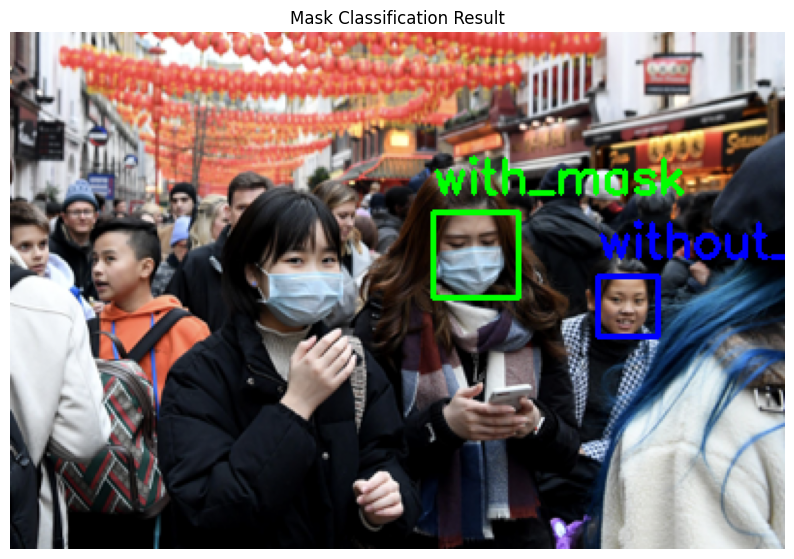

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

mask_model = SimpleCNN()
mask_model.load_state_dict(torch.load("mask_classifier.pth", map_location=torch.device('cpu')))
mask_model.eval()
mask_model.to(device)


class_names = {0: "with_mask", 1: "without_mask", 2: "mask_wore_incorrect"}
class_colors = {
    "with_mask": (0, 255, 0),
    "without_mask": (255, 0, 0),
    "mask_wore_incorrect": (0, 165, 255)
}


image_path = "/kaggle/input/face-mask-detection/images/maksssksksss104.png"
raw_image = cv2.imread(image_path)

if raw_image is None:
    print("Check the path ")
else:
    processed_img = raw_image.copy()
    grayscale_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)

    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    detected_faces = face_detector.detectMultiScale(grayscale_img, scaleFactor=1.1, minNeighbors=5)

    print(f"Number of faces found: {len(detected_faces)}")

    face_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    
    for (x, y, w, h) in detected_faces:
        face_crop = processed_img[y:y+h, x:x+w]
        rgb_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        face_img = Image.fromarray(rgb_crop)
        input_tensor = face_transform(face_img).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = mask_model(input_tensor)
            _, predicted_class = torch.max(logits, dim=1)
            class_label = class_names[predicted_class.item()]
            box_color = class_colors[class_label]

        
        cv2.rectangle(processed_img, (x, y), (x+w, y+h), box_color, 2)
        cv2.putText(processed_img, class_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, box_color, 2)

    
    final_result = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(final_result)
    plt.axis('off')
    plt.title("Mask Classification Result")
    plt.show()
